# Exploring the MIMIC CXR Dataset

In [1]:
from PIL import Image
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from pathlib import Path
import os

import matplotlib.pyplot as plt
import gzip

___
Basic structure of the dataset 

In [2]:
data_root = Path('/voyager/datasets/physionet.org/files/mimic-cxr-jpg/2.0.0/')
os.chdir(data_root)
!ls

files	     mimic-cxr-2.0.0-chexpert.csv.gz  mimic-cxr-2.0.0-split.csv.gz
index.html   mimic-cxr-2.0.0-metadata.csv.gz  README
LICENSE.txt  mimic-cxr-2.0.0-negbio.csv.gz    SHA256SUMS.txt


___
How to read the primary metadata list

In [3]:
df = pd.read_csv('mimic-cxr-2.0.0-metadata.csv.gz', header=0, sep=',')
print('\n'.join(list(df.keys())))

dicom_id
subject_id
study_id
PerformedProcedureStepDescription
ViewPosition
Rows
Columns
StudyDate
StudyTime
ProcedureCodeSequence_CodeMeaning
ViewCodeSequence_CodeMeaning
PatientOrientationCodeSequence_CodeMeaning


___
Finding images for a random sample

In [4]:
sample = df.sample()
sample

,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning
121449,a6780a95-ae8955a7-3bdee541-be199116-09131ac4,13238553,58261664,NaN,PA,1846,1466,21361226,164420.0,CHEST (PA AND LAT),postero-anterior,Erect


In [7]:
# scans are located in p{first 2 numbers of subject_id}/p{subject_id}/s{study_id}/{dicom_id}.jpg
subj = 'p' + str(sample.subject_id.item())
study = 's' + str(sample.study_id.item())
loc = Path('files') / subj[:3] / subj / study
!ls $loc

2355c4cc-0b107239-ccd55b20-0f68ff66-8de0738b.jpg  index.html
a6780a95-ae8955a7-3bdee541-be199116-09131ac4.jpg


In [8]:
images = [Image.open(im) for im in loc.glob('*.jpg')]

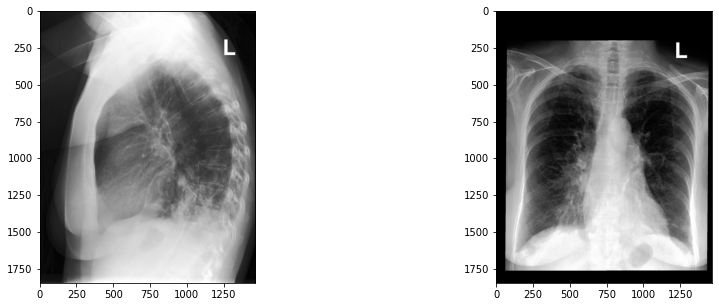

In [10]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
for ax, im in zip(axes.ravel(), images):
    ax.imshow(im, cmap='binary_r')

___
MIMIC CXR provides a trail test split

In [126]:
# essentially all of the data is for training ...
data_split = pd.read_csv('mimic-cxr-2.0.0-split.csv.gz')
print('Keys: ',', '.join(data_split.keys()))
counts = np.unique(data_split.split, return_counts=True)
print(counts[0])
print(100 * counts[1] / sum(counts[1]))

Keys:  dicom_id, study_id, subject_id, split
['test' 'train' 'validate']
[ 1.36803585 97.83882687  0.79313728]


___
We can check for chexpert annotations for a given example

In [14]:
chexpert = pd.read_csv('mimic-cxr-2.0.0-chexpert.csv.gz', header=0, sep=',')

In [15]:
chexpert[chexpert.study_id == sample.study_id.item()]

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
73520,13238553,58261664,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,0.0,NaN,1.0,NaN,NaN


In [129]:
# there is not a single row that doesn't have at least a NaN entry ! 
chexpert.dropna()

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices


In [136]:
# most have at least one label
chexpert.dropna(how='all', subset=chexpert.keys()[2:])

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,10000032,50414267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,10000032,53189527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,10000032,53911762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,10000032,56699142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,10000764,57375967,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227822,19999442,58708861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0
227823,19999733,57132437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
227824,19999987,55368167,1.0,-1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN
227825,19999987,58621812,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


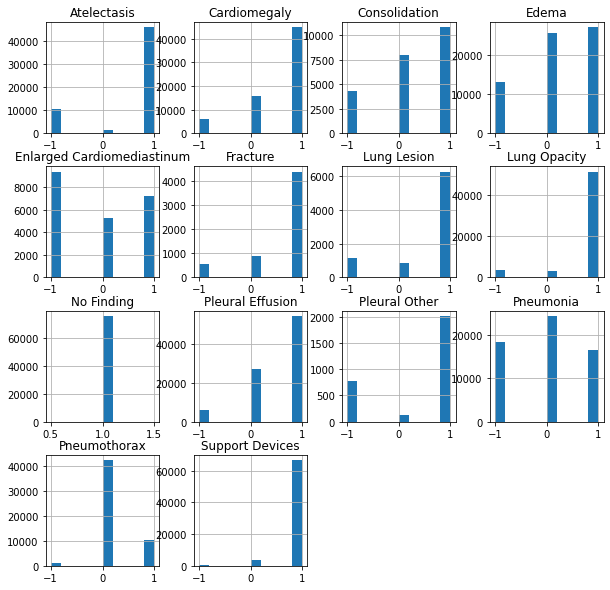

In [143]:
# all labels appear to be in {0,1,-1}
chexpert.iloc[:, 2:].dropna(how = 'all').hist(figsize=(10,10));